In [1]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
# import mahotas as mh
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display

/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

Using TensorFlow backend.


In [3]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [4]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [5]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

# from losses import *

def get_unet_128(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = LeakyReLU(alpha=0.15)(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = LeakyReLU(alpha=0.15)(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(alpha=0.15)(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(alpha=0.15)(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(alpha=0.15)(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU(alpha=0.15)(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = LeakyReLU(alpha=0.15)(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = LeakyReLU(alpha=0.15)(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = LeakyReLU(alpha=0.15)(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = LeakyReLU(alpha=0.15)(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = LeakyReLU(alpha=0.15)(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = LeakyReLU(alpha=0.15)(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = LeakyReLU(alpha=0.15)(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = LeakyReLU(alpha=0.15)(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = LeakyReLU(alpha=0.15)(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU(alpha=0.15)(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU(alpha=0.15)(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU(alpha=0.15)(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU(alpha=0.15)(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU(alpha=0.15)(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU(alpha=0.15)(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=Adam(lr=0.0001), loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])
    return model

In [6]:
model = get_unet_128()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
import glob
import numpy as np
from PIL import *
import PIL.Image

In [8]:
filelist = glob.glob('dataset/crop/RIM-ONEv2/images/*.jpg')              #change '/'
X = np.array([np.array(Image.open(fname)) for fname in filelist])
# filelist = glob.glob('dataset/crop/RIM-ONEv1/images/*.jpg')              #change '/'
# X = np.concatenate((X,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/DRIONS_DB/images/*.jpg')              #change '/'
# X = np.concatenate((X,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/DRISHTI_GS/images/*.jpg')              #change '/'
# X = np.concatenate((X,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/RIM-ONEv3/images/*.jpg')              #change '/'
# X = np.concatenate((X,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# X=X.reshape(841,3,128,128)
print(X.shape)
# X = np.concatenate((glu,nonglu),axis=0)
# print(X.shape)
# print(X[1,:].shape)


(455, 128, 128, 3)


In [9]:
filelist = glob.glob('dataset/crop/RIM-ONEv2/discs/*.png')              #change '/'
Y = np.array([np.array(Image.open(fname)) for fname in filelist])
# filelist = glob.glob('dataset/crop/RIM-ONEv1/discs/*.png')              #change '/'
# Y = np.concatenate((Y,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/DRIONS_DB/discs/*.png')              #change '/'
# Y = np.concatenate((Y,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/DRISHTI_GS/discs/*.png')              #change '/'
# Y = np.concatenate((Y,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
# filelist = glob.glob('dataset/crop/RIM-ONEv3/discs/*.png')              #change '/'
# Y = np.concatenate((Y,[np.array(Image.open(fname)) for fname in filelist]),axis=0)
Y = Y.reshape(455,128,128,1)
print(Y.shape)

(455, 128, 128, 1)


In [10]:
#Normalization

for i in range(455):
    X[i,:,:,:] = (X[i,:,:,:] - np.min(X[i,:,:,:])) / (np.max(X[i,:,:,:]) - np.min(X[i,:,:,:]))
    Y[i,:,:,:] = (Y[i,:,:,:] - np.min(Y[i,:,:,:])) / (np.max(Y[i,:,:,:]) - np.min(Y[i,:,:,:]))
    

In [11]:
#SplittingTheData

from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.13, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_val.shape, y_val.shape)

(335, 128, 128, 3) (60, 128, 128, 3) (335, 128, 128, 1) (60, 128, 128, 1) (60, 128, 128, 3) (60, 128, 128, 1)


In [12]:
#CallBackFunc

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
TensorBoard(log_dir='logs')]

/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
from keras.models import load_model
model.load_weights('weights/best_weights.hdf5')

In [14]:
epochs = 15
H = model.fit(X_train, y_train, batch_size=8, epochs=epochs, verbose=1,
              callbacks=callbacks,validation_data=(X_val, y_val))

Train on 335 samples, validate on 60 samples
Epoch 1/15
335/335 [==============================] - 500s 1s/step - loss: 0.0818 - mean_IOU_gpu: 0.8221 - dice_metric: 0.8996 - val_loss: 0.1006 - val_mean_IOU_gpu: 0.7861 - val_dice_metric: 0.8780
Epoch 2/15
335/335 [==============================] - 495s 1s/step - loss: 0.0734 - mean_IOU_gpu: 0.8366 - dice_metric: 0.9087 - val_loss: 0.0903 - val_mean_IOU_gpu: 0.8031 - val_dice_metric: 0.8889
Epoch 3/15
335/335 [==============================] - 494s 1s/step - loss: 0.0721 - mean_IOU_gpu: 0.8396 - dice_metric: 0.9104 - val_loss: 0.0989 - val_mean_IOU_gpu: 0.7925 - val_dice_metric: 0.8820
Epoch 4/15
335/335 [==============================] - 495s 1s/step - loss: 0.0712 - mean_IOU_gpu: 0.8402 - dice_metric: 0.9109 - val_loss: 0.1094 - val_mean_IOU_gpu: 0.7643 - val_dice_metric: 0.8641
Epoch 5/15
335/335 [==============================] - 495s 1s/step - loss: 0.0717 - mean_IOU_gpu: 0.8391 - dice_metric: 0.9103 - val_loss: 0.1130 - val_mean_IO

In [15]:
# model.fit(X_train, y_train, epochs=1, batch_size=1,shuffle=True,callbacks=callbacks,validation_data=(X_val, y_val))
scores = model.evaluate(X_test, y_test, batch_size=1, steps=None)
print(scores)
print('loss=',scores[0])
print('metric',scores[1],scores[2])

60/60 [==============================] - 25s 420ms/step
[0.10616323600212733, 0.7919622133175532, 0.8795565485954284]
loss= 0.10616323600212733
metric 0.7919622133175532 0.8795565485954284


In [15]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('models/second_model.h5')

# Deletes the existing model
del model  

# Returns a compiled model identical to the previous one
model = load_model('models/second_model.h5')

ValueError: Unknown loss function:log_dice_loss

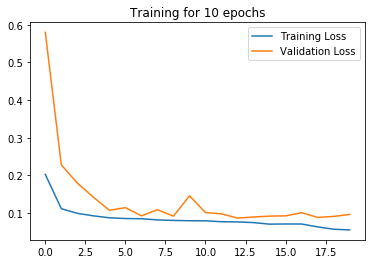

In [16]:
import matplotlib.pyplot as plt
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Training for ' +str(10)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [17]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Training for ' +str(10)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

KeyError: 'acc'